In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture

In [2]:
%matplotlib inline

In [3]:
sns.set_context("notebook",rc={"font.size": 24})
sns.set_style("whitegrid")

In [4]:
data = pd.read_excel("SAMBA scenario results all runs.xlsx","Capitalinv Variable and Fixed")

In [5]:
data.sample(5)

,DMD,FUEL,CC RE,DR,CO2,CC,Parameter (million USD),2013,2014,2015,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
535,2,3,1,3,3,1,AnnualVariableOperatingCost,23746.320138,25210.221537,14841.481087,...,47591.617705,49113.920569,50949.306116,52351.713976,54017.542667,55770.968414,57544.067653,59664.566961,61850.625793,62519.103308
116,1,1,3,1,2,1,CapitalInvestment,133.712600,21093.397216,30075.915485,...,46836.757059,44832.537643,49967.962637,49959.996212,52047.565269,51051.183890,48547.591357,51374.455575,62143.281602,64243.589213
150,1,1,3,3,2,1,AnnualFixedOperatingCost,6182.358917,6474.255984,6914.949080,...,11027.988320,11269.891029,11743.981526,12358.715046,12990.646562,13624.559261,14140.627249,14720.329088,15290.667158,15703.234552
822,3,3,1,1,3,1,AnnualFixedOperatingCost,6183.985644,6476.025518,6916.913614,...,13425.329719,13601.113124,13961.436712,14314.667327,14630.405443,14980.000285,15314.089469,15688.473637,16089.003848,16490.381083
47,1,1,1,3,2,2,CapitalInvestment,24.570676,29485.253111,44109.789118,...,54632.886452,59863.395668,67921.371344,79784.572814,81438.407844,89189.342243,87469.710244,84159.084347,90047.946738,74450.741479


In [7]:
new_data = data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).sum(axis=1).unstack("Parameter (million USD)").reset_index()

### separate uncertain factors from results

In [8]:
inputs = new_data[['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC']]

### results (costs)

In [9]:
new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].describe()

Parameter (million USD),CapitalInvestment,AnnualFixedOperatingCost,AnnualVariableOperatingCost
count,3.240000e+02,324.000000,3.240000e+02
mean,2.109219e+06,412459.069929,9.916623e+05
std,6.478034e+05,41429.216989,2.689545e+05
min,1.234211e+06,335244.175023,6.406939e+05
25%,1.601039e+06,386200.934999,7.948066e+05
50%,1.958794e+06,406839.405427,9.022494e+05
75%,2.414730e+06,433880.442881,1.139904e+06
max,4.319113e+06,521387.835738,1.881458e+06


In [10]:
new_data['tot_cost'] = new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

In [11]:
new_data['tot_cost'].describe()

count    3.240000e+02
mean     3.513340e+06
std      7.516254e+05
min      2.459950e+06
25%      2.932343e+06
50%      3.375900e+06
75%      3.950610e+06
max      6.076922e+06
Name: tot_cost, dtype: float64

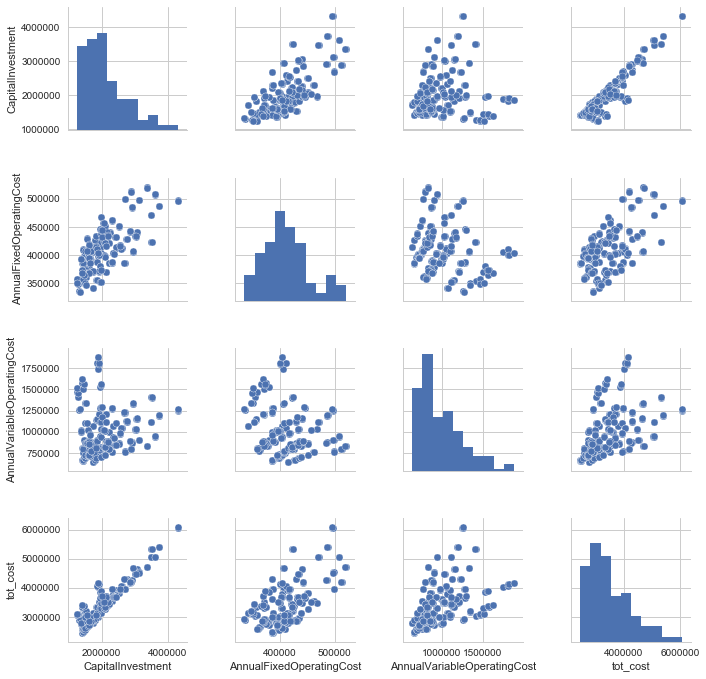

In [12]:
sns.pairplot(new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost','tot_cost']])

In [13]:
new_data['annual_cost'] = new_data[['AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

### clustering and scenario discovery functions 

In [19]:
def clustering(n_clusters,data,xstring,ystring):
    g = mixture.GaussianMixture(n_components=n_clusters)
    g.fit(data_norm)
    pred = g.predict(data_norm)+1
                    
    x=[]
    y=[]
    for i in range(0,len(data)):
        x.append(data[i][0])
        y.append(data[i][1])

    df = pd.DataFrame()
    df[xstring] = x
    df[ystring] = y
    df['class'] = pred
    
    return df

In [20]:
def get_prim(n_clusters, f_value,data,xstring,ystring,inputs):
    
    df = clustering(n_clusters,data,xstring,ystring)
    classes = df[['class']].drop_duplicates()['class']
    list_prim =[]
    sorted(classes)
        
    for i in range(1,max(classes)+1):
        list_prim.append(prim.Prim(inputs, (df['class']==i),threshold=0.5,threshold_type=">"))

    boxes = []

    for i in range(0,len(list_prim)):
        boxes.append(list_prim[i].find_box())
        obj = (f_value*boxes[i].peeling_trajectory['coverage']-(1-f_value)*boxes[i].peeling_trajectory['density'])**2
        if 1 in boxes[i].peeling_trajectory['coverage']:
            coverage1 = np.where(boxes[i].peeling_trajectory['coverage']==1)[0][0]
            obj = obj.drop(obj.index[[coverage1]])
        k = obj.argmin()
        boxes[i].select(k)
    
    return [boxes,df]

def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    a = 1/(maxima-minima)
    b = minima/(minima-maxima)
    data = a * data + b                    
    return data

In [21]:
oois = ['annual_cost','CapitalInvestment']

data = np.array([[new_data[oois[0]][0],new_data[oois[1]][0]]])
for i in range(1,len(new_data.index)):
    data = np.concatenate((data,np.array([[new_data[oois[0]][i],new_data[oois[1]][i]]])))

data_norm = normalize(data)

In [22]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

### looking for the clusters that gives the best PRIM results (the number of clusters is chosen by the algorithm) 

In [23]:
while n_clusters>2:

    condition = True

    for i in get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)[0]:
        if i.coverage+i.density < seuil:
            condition = False
        else:
            condition = condition&True
    if condition == True:
        break
    else:
        n_clusters = n_clusters - 1
        continue


#Plot of clusters


dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)
boxes = dummy[0]
df = dummy[1]

### the algorithm has found 3 clusters 

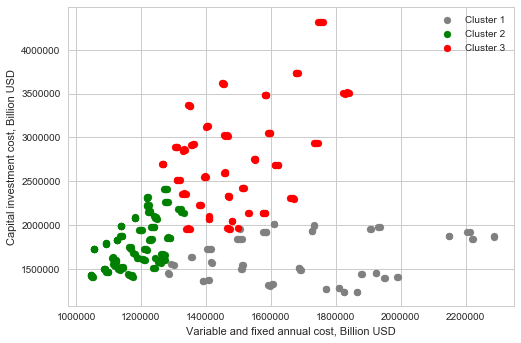

In [25]:
mycolors = ["grey","green","red","blue"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf.annual_cost,subdf.CapitalInvestment,label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.xlabel("Variable and fixed annual cost, Billion USD")
plt.ylabel("Capital investment cost, Billion USD")
plt.savefig("clusters.png")

### below are PRIM results for each cluster

#### cluster 1 (gray: low capital cost and high variable cost) is explained by no CO2 constraint and high discount rate 

In [26]:
boxes[0].limits

,min,max,qp values
CO2,3.0,3.0,6.286701e-15
DR,2.0,3.0,1.106845e-04


#### cluster 2 (green: lowest variable and fixed costs) is explained by a strong CO2 constraint and low electricity demand

In [27]:
boxes[1].limits

,min,max,qp values
DR,1.0,2.0,1.454294e-12
DMD,1.0,2.0,6.873636e-08


#### cluster 3 (red: high capital costs) is explained by a strong CO2 constraint, high demand and high discount rate 

In [28]:
boxes[2].limits

,min,max,qp values
CO2,1.0,2.0,5.475635e-07
DMD,2.0,3.0,2.269133e-05
DR,2.0,3.0,2.024737e-04


In [30]:
inputs.describe()

Parameter (million USD),DMD,FUEL,CC RE,DR,CO2,CC
count,324.00000,324.000000,324.00000,324.00000,324.00000,324.000000
mean,2.00000,2.000000,2.00000,2.00000,2.00000,1.500000
std,0.81776,1.001547,0.81776,0.81776,0.81776,0.500773
min,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000
25%,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000
50%,2.00000,2.000000,2.00000,2.00000,2.00000,1.500000
75%,3.00000,3.000000,3.00000,3.00000,3.00000,2.000000
max,3.00000,3.000000,3.00000,3.00000,3.00000,2.000000
